In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from copy import deepcopy
import sys
sys.path.append('../functions')
from IVfunctions import * 
from PreproFunctions import * 

# Approach 2: Top Down (Average/Sum Team Stats and attach to the Match Data) 

## Load in and Prepare the Player Data

In [2]:
#Load in the player data
df_players = pd.read_csv('../data/PlayerData_v1.csv',index_col=0)

## Load in and Prepare the Match Data

In [3]:
#Load in the match data
df_matches = pd.read_csv('../data/MatchData_v2.csv',index_col=0)

In [4]:
df_matches.columns.to_list()

['Team',
 'Opponent',
 'PointsF',
 'PointsA',
 'Venue',
 'Season',
 'Round',
 'Day',
 'Date',
 'Attendance',
 'Outcome',
 'H/A',
 'oppH/A',
 'City',
 'Rain (mm)',
 'Max Temp (C)',
 'Min Temp (C)',
 'Max Humid (%)',
 'Min Humid (%)',
 'Wind Speed (m/s)',
 'Solar Rad (MJ/sq m)']

In [5]:
df_matches_v3 = top_down_preproc(df_players,df_matches,2024) #Remove 2024 data

### Final Analysis Version Data: 

In [18]:
with pd.option_context('display.max_row',None):
    print(df_matches_v3[df_matches_v3['Team']=='Adelaide'][['Team','Opponent','Outcome','Last_Winner']])

         Team                Opponent  Outcome  Last_Winner
0    Adelaide           Port Adelaide        1          1.0
1    Adelaide  Greater Western Sydney        1          1.0
2    Adelaide                 Geelong        0          1.0
3    Adelaide               Fremantle        1          1.0
4    Adelaide              Gold Coast        1          1.0
5    Adelaide                  Sydney        0          1.0
6    Adelaide               Fremantle        1          1.0
7    Adelaide                Hawthorn        0          0.0
8    Adelaide                Hawthorn        0          0.0
9    Adelaide  Greater Western Sydney        1          1.0
10   Adelaide                St Kilda        1          1.0
11   Adelaide         North Melbourne        1          0.0
12   Adelaide               Fremantle        0          1.0
13   Adelaide                  Sydney        0          0.0
14   Adelaide                Richmond        0          1.0
15   Adelaide              Gold Coast   

In [7]:
#Join on the season_win_rate and win_streak for the opponent
df_matches_v3 = df_matches_v3.merge(df_matches_v3[['Opponent','Season','Round','season_win_rate','win_streak']],\
                    left_on=['Team','Season','Round'],right_on=['Opponent','Season','Round'],suffixes=('_team','_opp'))

#Remove Opponent_opp and rename Opponent_team
df_matches_v3 = df_matches_v3.drop('Opponent_opp',axis=1)
df_matches_v3.rename(columns={'Opponent_team':'Opponent'}, inplace=True)

In [8]:
#Rebin the win streak
def bin_winstreak(x):
    if x >= 0  and x <= 2:
        return 'a. [0,2]'
    else:
        return 'b. (2,Inf)'
     
df_matches_v3['win_streak_team_binned'] = df_matches_v3['win_streak_team'].apply(bin_winstreak) 
df_matches_v3['win_streak_opp_binned'] = df_matches_v3['win_streak_opp'].apply(bin_winstreak) 

In [9]:
#Encode and split data (statsmodels version)
df_ML_IT_sm,df_ML_OOT_sm,X_train_sm,y_train_sm,X_test_sm,y_test_sm = encode_split_data(df_matches_v3,2022,encode=False) 

In [10]:
#Encode and split data (other)
df_ML_IT,df_ML_OOT,X_train,y_train,X_test,y_test = encode_split_data(df_matches_v3,2022,encode=True) 

# Logistic Regression

## Information Values

In [11]:
#Prepare data for IV by binning with 10% deciles
X_train_sm_IV = decile_binning(X_train_sm)
df_IV,Xout = IV_summary(pd.concat([X_train_sm_IV,y_train_sm],axis=1),'Outcome')

G:\Local\Projects\AFL-Analytics-Project\Analysis\../functions\IVfunctions.py:71: RuntimeWarning: divide by zero encountered in scalar divide
  agg['WoE'] = agg.apply(lambda x: np.log(x.goods_perc/x.bads_perc),axis=1)


<Axes: xlabel='Variable'>

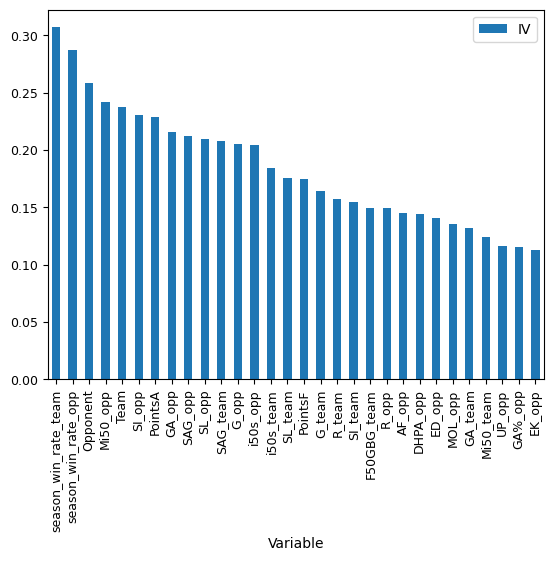

In [12]:
df_IV.head(30).plot.bar(x = 'Variable', y = 'IV', fontsize='9')

In [13]:
#Get columns based on information value
feature_cols = df_IV.head(30).Variable.to_list()
num_cols = deepcopy(feature_cols)
num_cols.remove('Team')
num_cols.remove('Opponent')

## Check for High Correlations

In [14]:
corr = X_train_sm[num_cols].corr()

corr.style.background_gradient(cmap='coolwarm')

,season_win_rate_team,season_win_rate_opp,Mi50_opp,SI_opp,PointsA,GA_opp,SAG_opp,SL_opp,SAG_team,G_opp,i50s_opp,i50s_team,SL_team,PointsF,G_team,R_team,SI_team,F50GBG_team,R_opp,AF_opp,DHPA_opp,ED_opp,MOL_opp,GA_team,Mi50_team,UP_opp,GA%_opp,EK_opp
season_win_rate_team,1.000000,0.053538,-0.557838,-0.554681,-0.619372,-0.566328,-0.596318,-0.601373,0.557506,-0.609976,-0.517446,0.525440,0.551938,0.550693,0.546269,0.497379,0.470016,0.459906,-0.450357,-0.347066,0.446248,-0.304488,-0.367109,0.501233,0.464343,-0.289255,-0.499814,-0.365368
season_win_rate_opp,0.053538,1.000000,-0.035313,-0.037325,-0.046048,-0.030194,-0.050641,-0.050869,0.031530,-0.044174,-0.053504,0.027675,0.039351,0.032917,0.031100,0.018561,0.027881,0.010565,-0.049278,-0.044229,0.001362,-0.016527,-0.022705,0.024824,0.045132,-0.017166,-0.037259,-0.021480
Mi50_opp,-0.557838,-0.035313,1.000000,0.818823,0.805985,0.808914,0.790411,0.787562,-0.266180,0.790237,0.646222,-0.304433,-0.256057,-0.215888,-0.210717,-0.227485,-0.179283,-0.351602,0.644811,0.584324,-0.352441,0.553253,0.470637,-0.199109,-0.271451,0.542893,0.581100,0.570963
SI_opp,-0.554681,-0.037325,0.818823,1.000000,0.901292,0.851538,0.909554,0.928927,-0.153894,0.869733,0.733492,-0.231633,-0.139541,-0.119081,-0.118509,-0.088942,-0.067110,-0.286053,0.798424,0.712575,-0.314490,0.694339,0.496820,-0.109117,-0.199754,0.664998,0.665353,0.607510
PointsA,-0.619372,-0.046048,0.805985,0.901292,1.000000,0.927332,0.910794,0.929147,-0.202249,0.993418,0.746453,-0.259417,-0.185114,-0.153432,-0.155424,-0.153620,-0.116378,-0.316874,0.819580,0.650975,-0.359693,0.573659,0.475677,-0.145250,-0.239593,0.528530,0.812949,0.570567
GA_opp,-0.566328,-0.030194,0.808914,0.851538,0.927332,1.000000,0.811805,0.833187,-0.194500,0.931258,0.665849,-0.235387,-0.179723,-0.151153,-0.152577,-0.135988,-0.115951,-0.295991,0.777549,0.627098,-0.301872,0.569639,0.456698,-0.132515,-0.220348,0.534615,0.768929,0.573386
SAG_opp,-0.596318,-0.050641,0.790411,0.909554,0.910794,0.811805,1.000000,0.961422,-0.198328,0.874909,0.818010,-0.273759,-0.196745,-0.179838,-0.177964,-0.139352,-0.138053,-0.312354,0.794085,0.661855,-0.344332,0.599777,0.500992,-0.171244,-0.266133,0.540294,0.639661,0.582473
SL_opp,-0.601373,-0.050869,0.787562,0.928927,0.929147,0.833187,0.961422,1.000000,-0.203580,0.889601,0.803533,-0.285406,-0.182041,-0.171109,-0.168800,-0.126764,-0.128980,-0.309435,0.813615,0.646321,-0.357896,0.604100,0.517606,-0.165061,-0.264854,0.531240,0.672861,0.586940
SAG_team,0.557506,0.031530,-0.266180,-0.153894,-0.202249,-0.194500,-0.198328,-0.203580,1.000000,-0.198763,-0.223387,0.816874,0.954505,0.896715,0.857058,0.810412,0.890608,0.601378,-0.062703,-0.009020,0.559508,-0.007262,-0.138554,0.793924,0.757265,-0.013461,-0.133072,-0.121892
G_opp,-0.609976,-0.044174,0.790237,0.869733,0.993418,0.931258,0.874909,0.889601,-0.198763,1.000000,0.708393,-0.246434,-0.180773,-0.151878,-0.155579,-0.151751,-0.113007,-0.305010,0.810334,0.632240,-0.339574,0.559242,0.451906,-0.142620,-0.231848,0.511280,0.834421,0.565324


In [15]:
with pd.option_context('display.max_row',None):
    print(df_IV)

                   Variable            IV
106    season_win_rate_team  3.069236e-01
115     season_win_rate_opp  2.872238e-01
118                Opponent  2.586884e-01
84                 Mi50_opp  2.418368e-01
117                    Team  2.375569e-01
96                   SI_opp  2.304447e-01
104                 PointsA  2.291425e-01
94                   GA_opp  2.158995e-01
54                  SAG_opp  2.117659e-01
55                   SL_opp  2.095388e-01
6                  SAG_team  2.075300e-01
56                    G_opp  2.053097e-01
68                 i50s_opp  2.040645e-01
20                i50s_team  1.842670e-01
7                   SL_team  1.753790e-01
103                 PointsF  1.747770e-01
8                    G_team  1.640460e-01
33                   R_team  1.570399e-01
48                  SI_team  1.547331e-01
45              F50GBG_team  1.495015e-01
81                    R_opp  1.491718e-01
78                   AF_opp  1.449083e-01
61                 DHPA_opp  1.441

In [20]:
def bucket_day(x):
    if x in ['Mon','Wed']:
        return 'Mon_Wed'
    else:
        return 'OTHER'
    
def bucket_venue(x):
    if x in ['Jiangwan Stadium','Riverway Stadium','Stadium Australia']:
        return 'Jiangwan_or_Riverway_or_StadAus'
    else:
        return 'OTHER'
    
    
X_train_sm['Day_binned'] = X_train_sm['Day'].apply(bucket_day)
X_test_sm['Day_binned'] = X_test_sm['Day'].apply(bucket_day)
df_ML_OOT_sm['Day_binned'] = df_ML_OOT_sm['Day'].apply(bucket_day)

X_train_sm['Venue_binned'] = X_train_sm['Venue'].apply(bucket_venue)
X_test_sm['Venue_binned'] = X_test_sm['Venue'].apply(bucket_venue)
df_ML_OOT_sm['Venue_binned'] = df_ML_OOT_sm['Venue'].apply(bucket_venue)

X_train_sm['DE_perc_opp'] = X_train_sm['DE%_opp']
X_test_sm['DE_perc_opp'] = X_test_sm['DE%_opp']
df_ML_OOT_sm['DE_perc_opp'] = df_ML_OOT_sm['DE%_opp']


In [109]:
log_reg = smf.logit("Outcome ~ G_opp + season_win_rate_team + season_win_rate_opp + HA + oppHA+Last_Winner", data=pd.concat([X_train_sm,y_train_sm],axis=1)).fit()

Optimization terminated successfully.
         Current function value: 0.604311
         Iterations 5


In [110]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                 2053
Model:                          Logit   Df Residuals:                     2046
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:                  0.1282
Time:                        22:35:58   Log-Likelihood:                -1240.6
converged:                       True   LL-Null:                       -1423.0
Covariance Type:            nonrobust   LLR p-value:                 1.044e-75
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.9503      0.405      2.344      0.019       0.156       1.745
HA[T.H]                  0.3557      0.114      3.118      0.002       0.132       0.579
oppHA[T.H]  

## Variance Inflation Factor

In [134]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
vif_data = pd.DataFrame()
X = X_train_sm[['G_opp','season_win_rate_team','season_win_rate_opp','Last_Winner']]
X_cats = pd.get_dummies(X_train_sm[['HA','oppHA']],drop_first=True).astype(int)
X = pd.concat([X,X_cats],axis=1)

vif_data["feature"] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]

In [135]:
vif_data

,feature,VIF
0,G_opp,9.204319
1,season_win_rate_team,5.844067
2,season_win_rate_opp,6.706727
3,Last_Winner,2.308620
4,HA_H,2.919571
5,oppHA_H,2.942440


### Correlations

In [136]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

,G_opp,season_win_rate_team,season_win_rate_opp,Last_Winner,HA_H,oppHA_H
G_opp,1.000000,-0.609976,-0.044174,-0.166692,0.136378,0.053470
season_win_rate_team,-0.609976,1.000000,0.053538,0.261457,-0.072240,0.024034
season_win_rate_opp,-0.044174,0.053538,1.000000,-0.286880,-0.007757,-0.050753
Last_Winner,-0.166692,0.261457,-0.286880,1.000000,-0.040949,0.068475
HA_H,0.136378,-0.072240,-0.007757,-0.040949,1.000000,-0.508062
oppHA_H,0.053470,0.024034,-0.050753,0.068475,-0.508062,1.000000


### Training Data

In [114]:
y_train_pred = log_reg.predict(X_train_sm) 

from sklearn.metrics import roc_curve,roc_auc_score
fpr,tpr, thresholds = roc_curve(y_train_sm,y_train_pred)

Text(0.5, 1.0, 'Training ROC Curve')

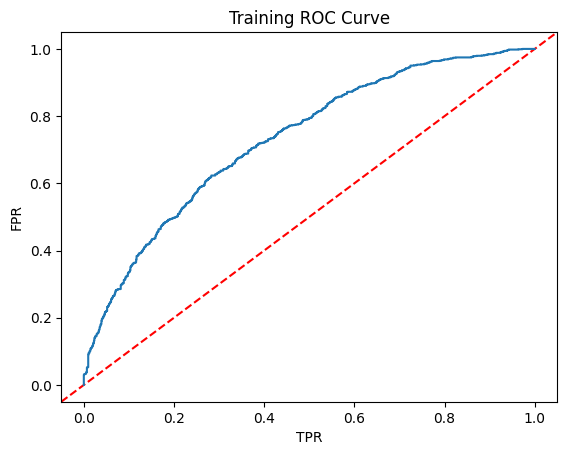

In [115]:
fig,ax = plt.subplots()

ax.axline((0,0),slope=1,color='red',linestyle='--')
ax.plot(fpr,tpr)
ax.set_xlabel('TPR')
ax.set_ylabel('FPR')
ax.set_title('Training ROC Curve')

In [116]:
AUC = roc_auc_score(y_train_sm,y_train_pred)
Gini = 2*AUC-1
print('ROC AUC: ',AUC*100,'\nGini: ',Gini*100)

ROC AUC:  73.14648733702698 
Gini:  46.29297467405395


### Test Data

In [117]:
y_test_pred = log_reg.predict(X_test_sm) 

from sklearn.metrics import roc_curve,roc_auc_score
fpr,tpr, thresholds = roc_curve(y_test_sm,y_test_pred)

Text(0.5, 1.0, 'Test ROC Curve')

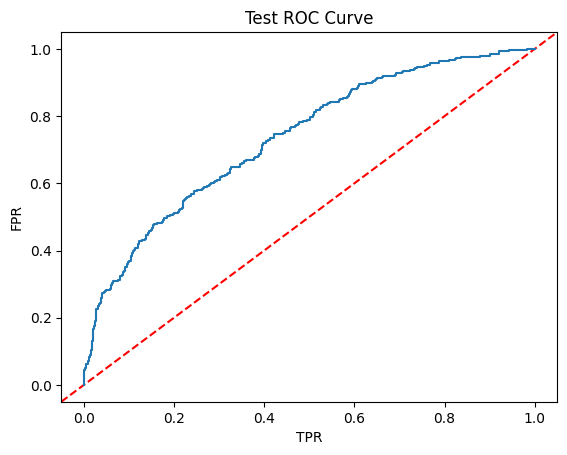

In [118]:
fig,ax = plt.subplots()

ax.axline((0,0),slope=1,color='red',linestyle='--')
ax.plot(fpr,tpr)
ax.set_xlabel('TPR')
ax.set_ylabel('FPR')
ax.set_title('Test ROC Curve')

In [119]:
AUC = roc_auc_score(y_test_sm,y_test_pred)
Gini = 2*AUC-1
print('ROC AUC: ',AUC*100,'\nGini: ',Gini*100)

ROC AUC:  73.43382807668523 
Gini:  46.867656153370454


### OOT Data

In [120]:
y_pred_OOT = log_reg.predict(df_ML_OOT_sm)
y_OOT = df_ML_OOT_sm['Outcome']
fpr,tpr, thresholds = roc_curve(y_OOT,y_pred_OOT)

Text(0.5, 1.0, 'OOT ROC Curve')

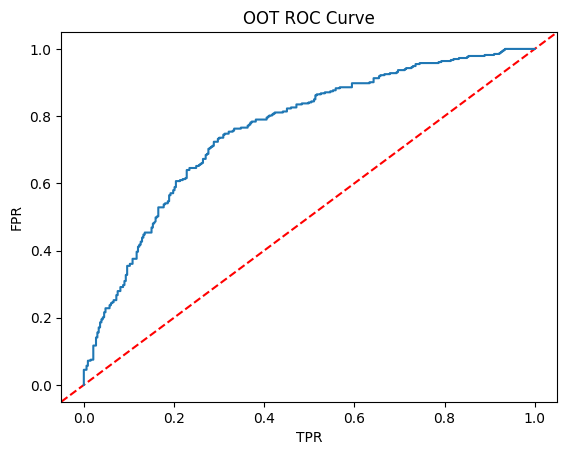

In [121]:
fig,ax = plt.subplots()

ax.axline((0,0),slope=1,color='red',linestyle='--')
ax.plot(fpr,tpr)
ax.set_xlabel('TPR')
ax.set_ylabel('FPR')
ax.set_title('OOT ROC Curve')

In [122]:
AUC = roc_auc_score(y_OOT,y_pred_OOT)
Gini = 2*AUC-1
print('ROC AUC: ',AUC*100,'\nGini: ',Gini*100)

ROC AUC:  76.2000739478217 
Gini:  52.4001478956434


In [123]:
#Check against original dataset
df_matches_v3['Predicted'] = log_reg.predict(df_matches_v3)

In [124]:
#Get the other side of the match
df_matches_v3 = df_matches_v3.merge(df_matches_v3[['Season','Round','Opponent','Predicted']],
                                    left_on=['Season','Round','Team'],right_on=['Season','Round','Opponent'],\
                                    suffixes=('_team','_opp')) 

df_matches_v3=df_matches_v3.rename(columns={'Opponent_team':'Opponent'})

MergeError: Passing 'suffixes' which cause duplicate columns {'Predicted_team'} is not allowed.

In [125]:
df_matches_v3['Predicted_team2'] = 1 - df_matches_v3['Predicted_opp']
df_matches_v3['Predicted_final'] = (df_matches_v3['Predicted_team2'] + df_matches_v3['Predicted_team'] )/2
df_matches_v3[['Team','Opponent','Season','Outcome','Predicted_final']]

,Team,Opponent,Season,Outcome,Predicted_final
0,Adelaide,Port Adelaide,2012,1,0.788865
1,Adelaide,Greater Western Sydney,2012,1,0.874955
2,Adelaide,Geelong,2012,0,0.563615
3,Adelaide,Fremantle,2012,1,0.711541
4,Adelaide,Gold Coast,2012,1,0.900102
...,...,...,...,...,...
3595,Western Bulldogs,Greater Western Sydney,2023,0,0.618671
3596,Western Bulldogs,Richmond,2023,1,0.695960
3597,Western Bulldogs,Hawthorn,2023,0,0.643496
3598,Western Bulldogs,West Coast,2023,0,0.864752


In [126]:
acc_agg = df_matches_v3[['Season','Team','Outcome','Predicted_final']].groupby(['Season','Team']).mean().reset_index()

In [127]:
team_list = list(df_matches_v3['Team'].unique())

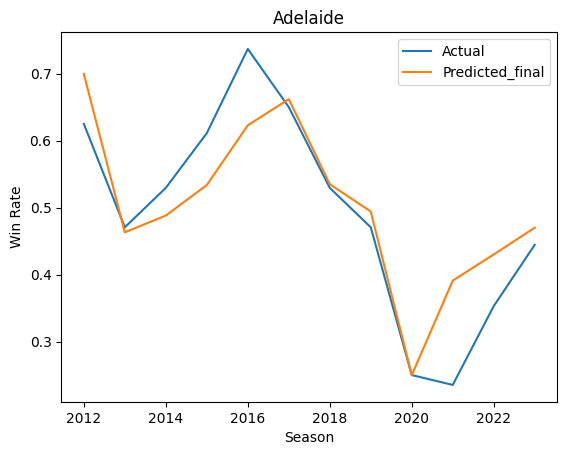

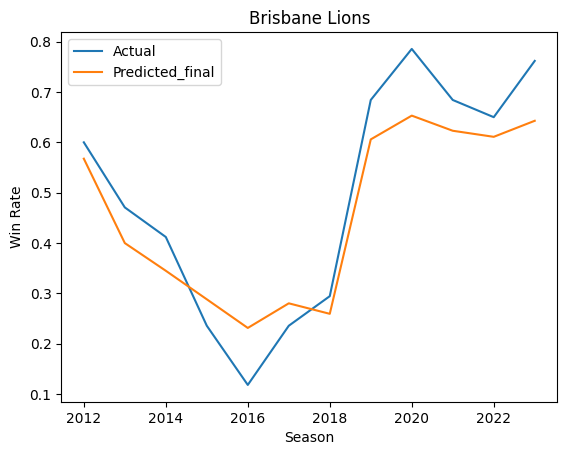

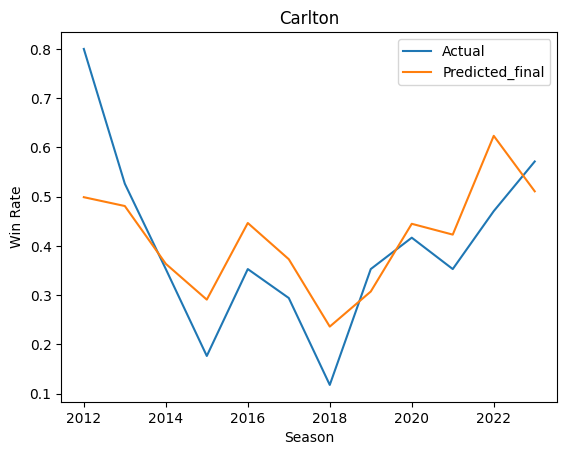

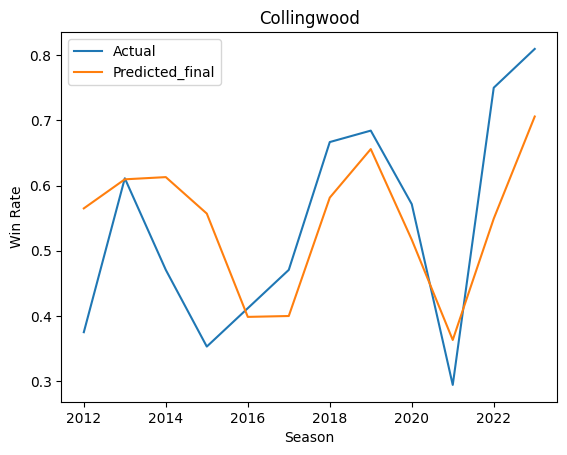

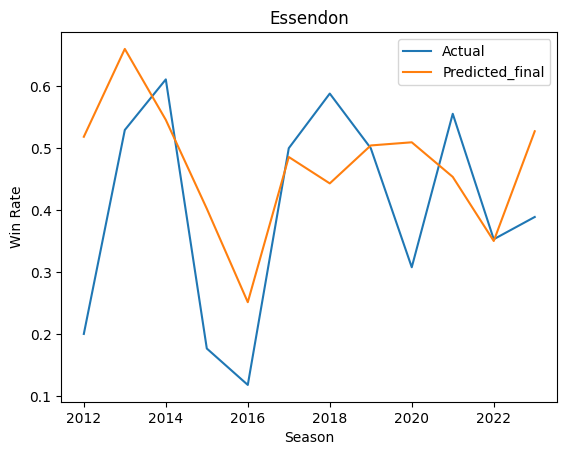

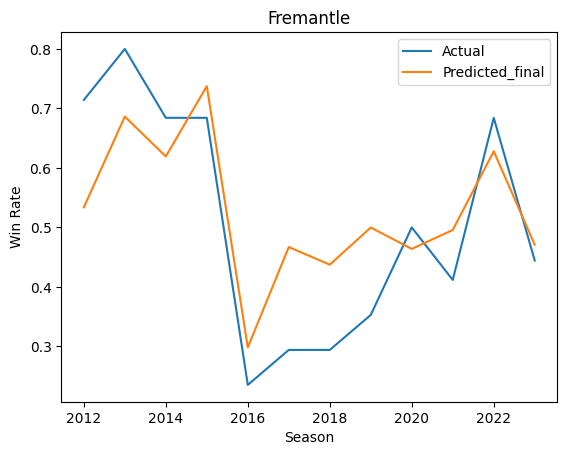

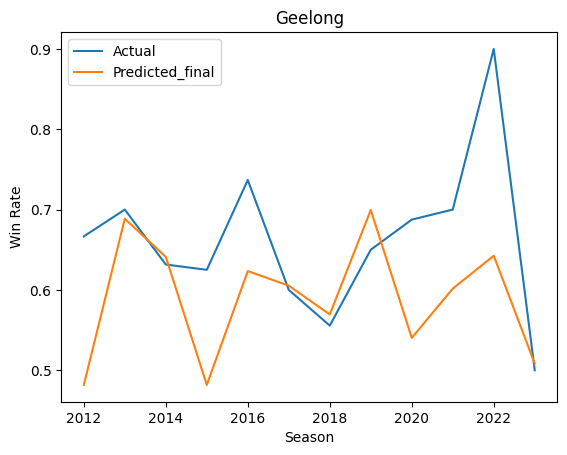

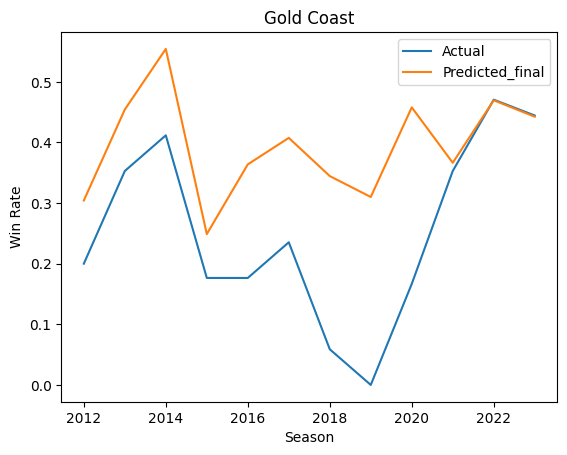

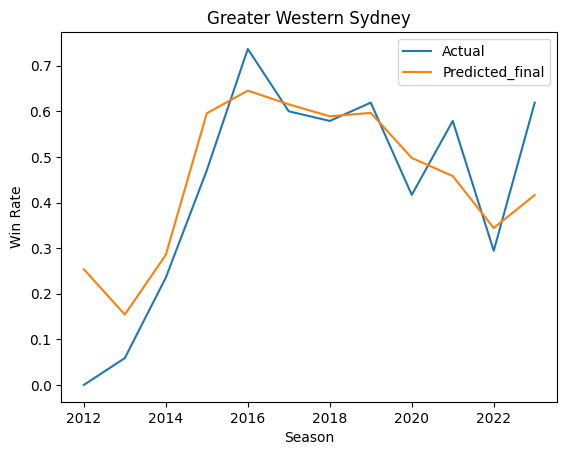

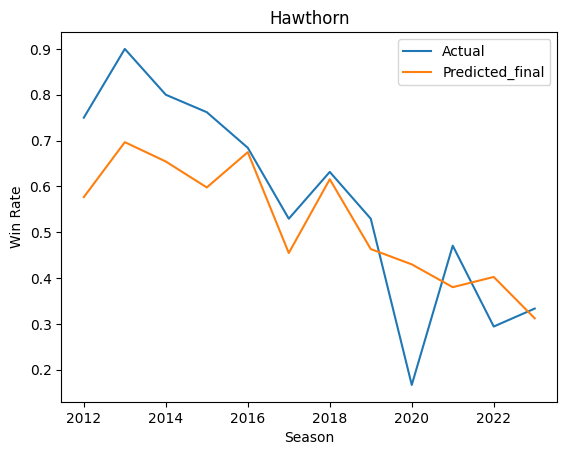

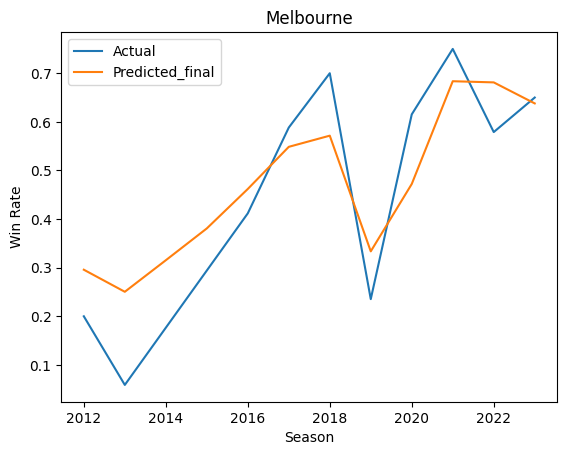

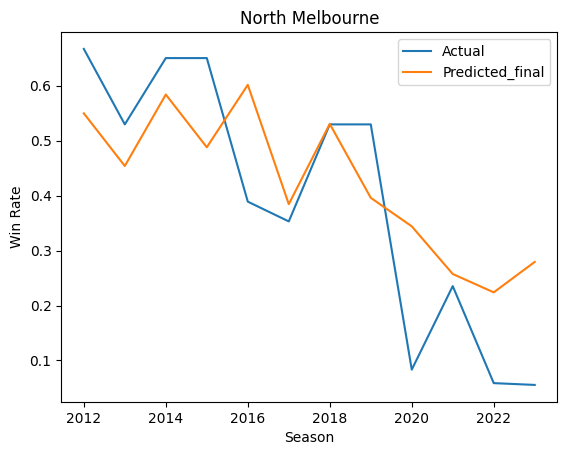

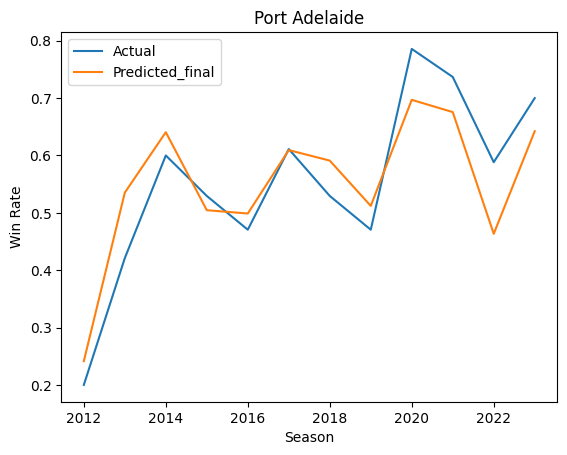

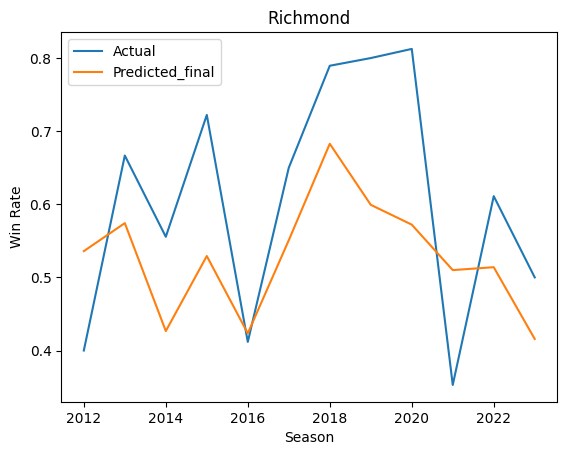

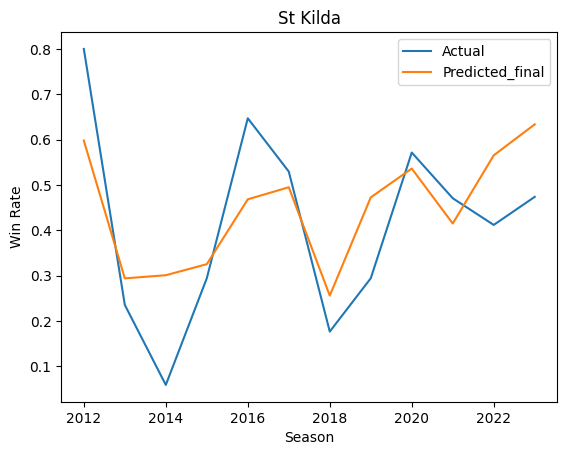

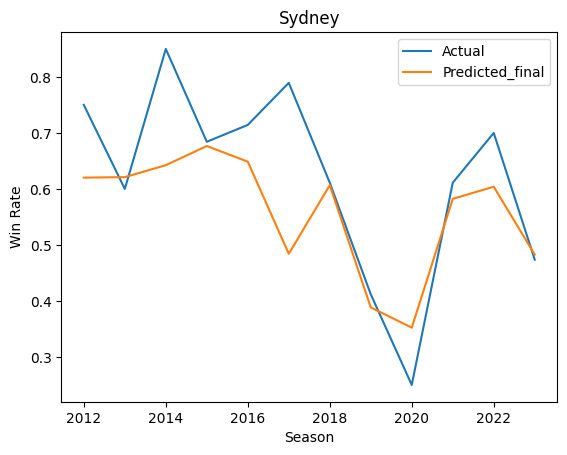

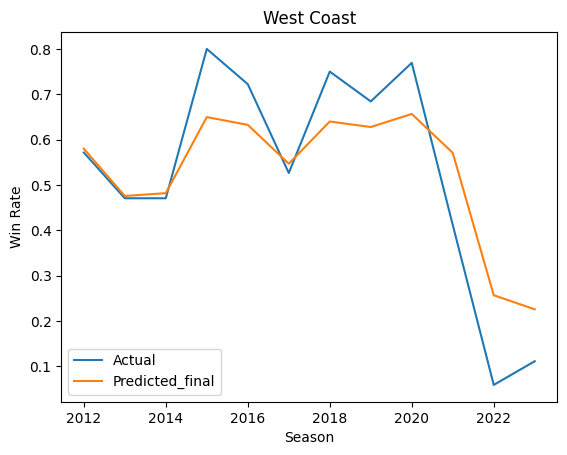

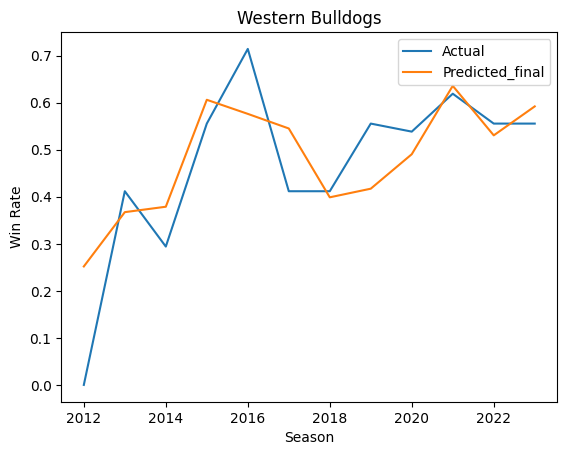

In [128]:
for team in team_list:
    team_ts = acc_agg[acc_agg['Team']==team]
    fig,ax = plt.subplots()
    
    ax.plot(team_ts['Season'],team_ts[['Outcome','Predicted_final']])
    ax.set_title(team)
    ax.set_xlabel('Season')
    ax.set_ylabel('Win Rate')
    ax.legend(['Actual','Predicted_final'])
    

In [129]:
df_matches_v3[['Team','Outcome','Predicted_final']].groupby('Team').mean()

,Outcome,Predicted_final
Team,,
Adelaide,0.497462,0.504349
Brisbane Lions,0.495000,0.458407
Carlton,0.378238,0.413376
Collingwood,0.558252,0.547735
Essendon,0.419689,0.468101
Fremantle,0.507538,0.535599
Geelong,0.665094,0.601016
Gold Coast,0.260638,0.397950
Greater Western Sydney,0.475490,0.472707


In [132]:
df_matches_v3['Predicted_round'] = (df_matches_v3['Predicted_final'] >= 0.5).astype(int) 

In [133]:
from sklearn.metrics import accuracy_score,precision_score

acc = accuracy_score(df_matches_v3['Outcome'],df_matches_v3['Predicted_round'])
prec = precision_score(df_matches_v3['Outcome'],df_matches_v3['Predicted_round'])
print('Whole Time Range:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

df_OOT_temp = df_matches_v3[df_matches_v3['Season']>=2022]
acc = accuracy_score(df_OOT_temp['Outcome'],df_OOT_temp['Predicted_round'])
prec = precision_score(df_OOT_temp['Outcome'],df_OOT_temp['Predicted_round'])
print('OOT Range:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

Whole Time Range:
-------------
 
Accuracy:  67.17 % 
Precision:  67.17 %

OOT Range:
-------------
 
Accuracy:  69.67 % 
Precision:  69.67 %



### NOTES

- Training Gini is somewhat lower than ideal.
- Accuracy is not amazing at 67%

# Random Forest

## Recursive Feature Elimination

In [57]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

#Get Team and Opponent features
team_opp_cols = X_train.filter(regex=('(Team_*.|Opponent_.*)')).columns.to_list()

selector = RFE(RandomForestClassifier(random_state=5432,n_jobs=-1),n_features_to_select=15,step=1)
selector.fit(X_train.drop(team_opp_cols,axis=1),y_train)

RFE(estimator=RandomForestClassifier(n_jobs=-1, random_state=5432),
    n_features_to_select=15)

In [76]:
rf_features = X_train.drop(team_opp_cols,axis=1).iloc[:,selector.support_].columns.to_list()

In [77]:
rf_model = RandomForestClassifier(random_state=5432,n_jobs=-1)

rf_model.fit(X_train[rf_features],y_train)
#rf_model.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=5432)

In [78]:
importances = rf_model.feature_importances_
forest_importances = pd.Series(importances,index=rf_features).sort_values()

<Axes: >

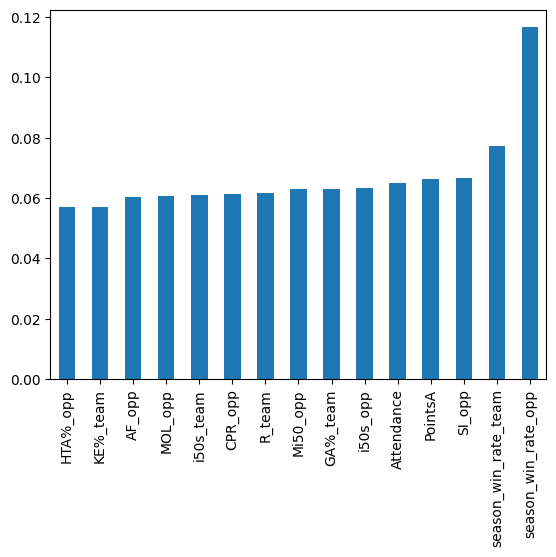

In [79]:
forest_importances.plot.bar()

In [80]:
y_pred_test = rf_model.predict(X_test[rf_features])
acc = accuracy_score(y_test,y_pred_test)
print('Test Data:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

Test Data:
-------------
 
Accuracy:  61.86 % 
Precision:  69.67 %



In [81]:
y_pred_OOT = rf_model.predict(df_ML_OOT[rf_features])
y_OOT = df_ML_OOT['Outcome']
acc = accuracy_score(y_OOT,y_pred_OOT)
print('OOT Range:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

OOT Range:
-------------
 
Accuracy:  64.41 % 
Precision:  69.67 %



In [82]:
df_compare = pd.DataFrame({'LogReg':df_OOT_temp['Predicted_round'],'RF':y_pred_OOT})
pd.crosstab(df_compare['LogReg'],df_compare['RF'])

RF,0,1
LogReg,,
0,234,99
1,50,283


### Notes

Random Forest has lower performance than logistic regression. However may prove useful in ensemble voting.

# SVM 

In [83]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

log_reg_feats = ['win_streak_team','win_streak_opp','PointsA','i50s_team','G_opp','season_win_rate_team','season_win_rate_opp','HA_H','oppHA_H']

svc_model = make_pipeline(StandardScaler(),SVC(kernel='linear'))
svc_model.fit(X_train[log_reg_feats],y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

In [84]:
y_pred_test = svc_model.predict(X_test[log_reg_feats])
acc = accuracy_score(y_test,y_pred_test)
print('Test Data:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

Test Data:
-------------
 
Accuracy:  66.29 % 
Precision:  69.67 %



In [85]:
y_pred_OOT = svc_model.predict(df_ML_OOT[log_reg_feats])
y_OOT = df_ML_OOT['Outcome']
acc = accuracy_score(y_OOT,y_pred_OOT)
print('OOT Range:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

OOT Range:
-------------
 
Accuracy:  68.62 % 
Precision:  69.67 %



### Note

SVM shows similar performance to logistic regression. However, not useful in ensemble voting since it's picking up the same wins in most cases.

In [86]:
df_compare = pd.DataFrame({'LogReg':df_OOT_temp['Predicted_round'],'SVM':y_pred_OOT})

In [87]:
pd.crosstab(df_compare['LogReg'],df_compare['SVM'])

SVM,0,1
LogReg,,
0,292,41
1,24,309


# XGBOOST

In [90]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [100]:
param_grid = {
    'learning_rate':[0.3,0.25,0.20,0.15,0.1,0.05,0.01,0.001],
    'max_depth': [3,5,7,10,20],
    'subsample': [0.5,0.7,1]
}

xgb_model = xgb.XGBClassifier(device="cuda")

grid_search = GridSearchCV(xgb_model,param_grid,cv=5,scoring='accuracy')
grid_search.fit(X_train.drop(['win_streak_team_binned_a. [0,2]','win_streak_team_binned_b. (2,Inf)',
                            'win_streak_opp_binned_a. [0,2]','win_streak_opp_binned_b. (2,Inf)'],axis=1),y_train)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1}
Best score:  0.6653504243071627


In [102]:
xgb_model = xgb.XGBClassifier(learning_rate=0.1,max_depth=3,subsample=1,random_state=5432)
xgb_model.fit(X_train.drop(['win_streak_team_binned_a. [0,2]','win_streak_team_binned_b. (2,Inf)',
                            'win_streak_opp_binned_a. [0,2]','win_streak_opp_binned_b. (2,Inf)'],axis=1),y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=5432, ...)

In [104]:
y_pred_test = xgb_model.predict(X_test.drop(['win_streak_team_binned_a. [0,2]','win_streak_team_binned_b. (2,Inf)',
                            'win_streak_opp_binned_a. [0,2]','win_streak_opp_binned_b. (2,Inf)'],axis=1))
acc = accuracy_score(y_test,y_pred_test)
print('Test Data:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

Test Data:
-------------
 
Accuracy:  65.04 % 
Precision:  69.67 %



In [107]:
y_pred_OOT = xgb_model.predict(df_ML_OOT.drop(['win_streak_team_binned_a. [0,2]','win_streak_team_binned_b. (2,Inf)',
                            'win_streak_opp_binned_a. [0,2]','win_streak_opp_binned_b. (2,Inf)','Outcome','Season'],axis=1))
y_OOT = df_ML_OOT['Outcome']
acc = accuracy_score(y_OOT,y_pred_OOT)
print('OOT Range:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

OOT Range:
-------------
 
Accuracy:  68.47 % 
Precision:  69.67 %



In [108]:
df_compare = pd.DataFrame({'LogReg':df_OOT_temp['Predicted_round'],'XGB':y_pred_OOT})
pd.crosstab(df_compare['LogReg'],df_compare['XGB'])

XGB,0,1
LogReg,,
0,231,102
1,28,305


## NOTES

Useful in a voting ensemble. Try the following:
- Feature Selection for XGB.
- Further Fine Tuning.

In [ ]:
## Try PCA 